<a href="https://colab.research.google.com/github/anushaharikrishnan/FaceMaskDetection/blob/main/FACEMASKDETECTIONROUGH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [4]:
print(len(os.listdir('/content/drive/MyDrive/Face Mask Detection/dataset/with mask')))
print(len(os.listdir('/content/drive/MyDrive/Face Mask Detection/dataset/without mask')))

690
686


In [5]:
try:
  os.mkdir('/tmp/withmask-or-withoutmask')
  os.mkdir('/tmp/withmask-or-withoutmask/training')
  os.mkdir('/tmp/withmask-or-withoutmask/testing')
  os.mkdir('/tmp/withmask-or-withoutmask/training/withmask')
  os.mkdir('/tmp/withmask-or-withoutmask/training/withoutmask')
  os.mkdir('/tmp/withmask-or-withoutmask/testing/withmask')
  os.mkdir('/tmp/withmask-or-withoutmask/testing/withoutmask')

except OSError:
  pass

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]
  
  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)
  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)



MASK_SOURCE_DIR="/content/drive/MyDrive/Face Mask Detection/dataset/with mask/"
TRAINING_MASK_DIR="/tmp/withmask-or-withoutmask/training/withmask/"
TESTING_MASK_DIR="/tmp/withmask-or-withoutmask/testing/withmask/"
WITHOUTMASK_SOURCE_DIR="/content/drive/MyDrive/Face Mask Detection/dataset/without mask/"
TRAINING_WITHOUTMASK_DIR="/tmp/withmask-or-withoutmask/training/withoutmask/"
TESTING_WITHOUTMASK_DIR="/tmp/withmask-or-withoutmask/testing/withoutmask/"

split_size = .7

split_data(MASK_SOURCE_DIR,TRAINING_MASK_DIR,TESTING_MASK_DIR,split_size)
split_data(WITHOUTMASK_SOURCE_DIR,TRAINING_WITHOUTMASK_DIR,TESTING_WITHOUTMASK_DIR,split_size)

In [7]:
print(len(os.listdir('/tmp/withmask-or-withoutmask/training/withmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/testing/withmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/training/withoutmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/testing/withoutmask/')))

train_withmask_fnames=os.listdir(TRAINING_MASK_DIR)
train_withoutmask_fnames=os.listdir(TRAINING_WITHOUTMASK_DIR)
test_withmask_fnames=os.listdir(TESTING_MASK_DIR)
test_withoutmask_fnames=os.listdir(TESTING_WITHOUTMASK_DIR)

print(train_withmask_fnames[:10])
print(train_withoutmask_fnames[:10])
print(test_withmask_fnames[:10])
print(test_withoutmask_fnames[:10])

621
347
624
350
['183-with-mask.jpg', '318-with-mask.jpg', 'augmented_image_247.jpg', '330-with-mask.jpg', '13-with-mask.jpg', '311-with-mask.jpg', '221-with-mask.jpg', 'augmented_image_6.jpg', 'augmented_image_142.jpg', '467-with-mask.jpg']
['13.jpg', 'augmented_image_229.jpg', '287.jpg', 'augmented_image_275.jpg', 'augmented_image_142.jpg', 'augmented_image_109.jpg', '170.jpg', 'augmented_image_111.jpg', '107.jpg', '250.jpg']
['386-with-mask.jpg', '183-with-mask.jpg', '318-with-mask.jpg', 'augmented_image_247.jpg', '13-with-mask.jpg', '221-with-mask.jpg', 'augmented_image_6.jpg', 'augmented_image_142.jpg', 'augmented_image_109.jpg', '235-with-mask.jpg']
['57.jpg', '287.jpg', 'augmented_image_275.jpg', 'augmented_image_109.jpg', 'augmented_image_111.jpg', '250.jpg', 'augmented_image_307.jpg', '388.jpg', 'augmented_image_243.jpg', '221.jpg']


In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

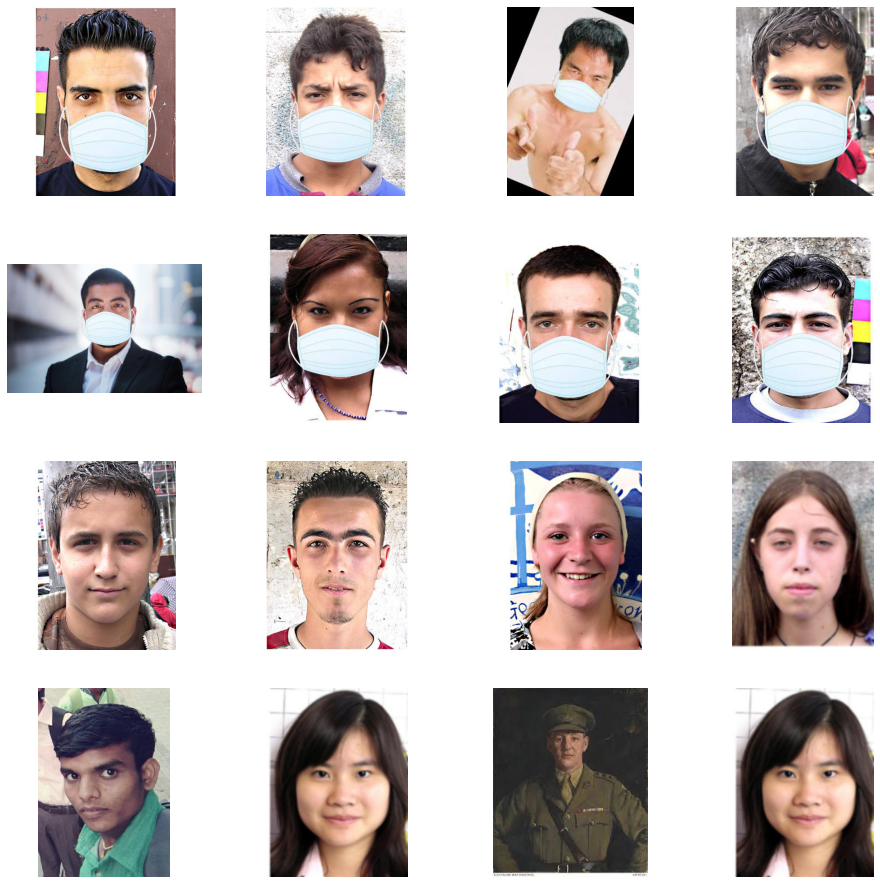

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(TRAINING_MASK_DIR, fname) 
                for fname in train_withmask_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(TRAINING_WITHOUTMASK_DIR, fname) 
                for fname in train_withoutmask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.998):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 645248)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

In [11]:
TRAINING_DIR = "/tmp/withmask-or-withoutmask/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    target_size=(300, 300))


VALIDATION_DIR = "/tmp/withmask-or-withoutmask/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.,
                                        rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=50,
                                                              class_mode='binary',
                                                              target_size=(300, 300))

Found 1245 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [12]:
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)



history = model.fit(
      train_generator,
      steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=4,  # 1000 images = batch_size * steps
      verbose=2,
      callbacks=[callbacks])

Epoch 1/50
10/10 - 138s - loss: 42.3966 - accuracy: 0.5080 - val_loss: 0.6648 - val_accuracy: 0.5550
Epoch 2/50
10/10 - 132s - loss: 0.7793 - accuracy: 0.4900 - val_loss: 0.6829 - val_accuracy: 0.5350
Epoch 3/50
10/10 - 131s - loss: 0.6982 - accuracy: 0.5220 - val_loss: 0.6839 - val_accuracy: 0.5300
Epoch 4/50
10/10 - 130s - loss: 1.4656 - accuracy: 0.5859 - val_loss: 30.2294 - val_accuracy: 0.4750
Epoch 5/50
10/10 - 131s - loss: 3.4935 - accuracy: 0.5920 - val_loss: 0.7748 - val_accuracy: 0.4600
Epoch 6/50
10/10 - 130s - loss: 0.7106 - accuracy: 0.7111 - val_loss: 0.5418 - val_accuracy: 0.8100
Epoch 7/50
10/10 - 131s - loss: 0.5174 - accuracy: 0.7580 - val_loss: 0.8611 - val_accuracy: 0.6550
Epoch 8/50
10/10 - 132s - loss: 0.7272 - accuracy: 0.7340 - val_loss: 0.4076 - val_accuracy: 0.8200
Epoch 9/50
10/10 - 131s - loss: 1.7247 - accuracy: 0.7480 - val_loss: 1.2440 - val_accuracy: 0.5900
Epoch 10/50
10/10 - 130s - loss: 0.4926 - accuracy: 0.7960 - val_loss: 0.4710 - val_accuracy: 0.78

<Figure size 432x288 with 0 Axes>

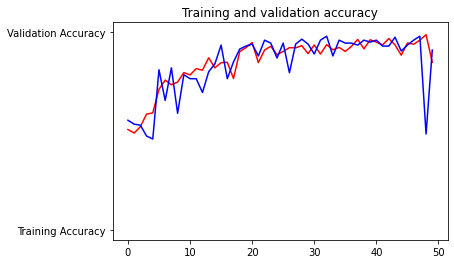

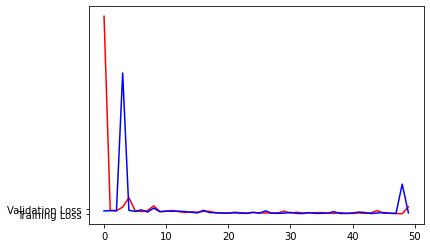

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [24]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a without mask")
  else:
    print(fn + " is with mask")


Saving withoutmasknew.jpg to withoutmasknew (1).jpg
Saving withoutmask2.jpeg to withoutmask2 (4).jpeg
Saving withoutmask.jpg to withoutmask.jpg
Saving withmasknew2.jpg to withmasknew2 (1).jpg
Saving withmasknew.jpg to withmasknew (1).jpg
Saving with mask.jpg to with mask (1).jpg
[1.]
withoutmasknew.jpg is a without mask
[0.]
withoutmask2.jpeg is with mask
[1.]
withoutmask.jpg is a without mask
[0.]
withmasknew2.jpg is with mask
[0.]
withmasknew.jpg is with mask
[0.]
with mask.jpg is with mask
